## 목표
#### DTW를 이용한 Well Correlation 분석
#### 파이프 라인 구축

In [2]:
# install package for DTW
!pip install dtwalign

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 1.1 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 4.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.5/25.5 MB 4.3 MB/s eta 0:00:0000:0100:01


In [1]:
# import libraries
import pandas as pd
import numpy as np
import glob
import os
import math
import shutil #used to zip predictions for submission

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks")

from dtwalign import dtw
from dtwalign import dtw_from_distance_matrix
from scipy.ndimage import gaussian_filter
from scipy import interpolate

# import sklearn libararies
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

import xgboost
import lightgbm

np.random.seed(10)

c:\Users\DELL\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import dtw

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



## 데이터 불러오기

In [3]:
well_list = os.listdir('data/train/')

if '.DS_Store' in well_list:
    well_list.remove('.DS_Store')

per_well = []

for i in well_list:
    per_well.append(pd.read_csv('data/train/{}'.format(i)))

In [12]:
for i in per_well:
    i.loc[i['GR']>200, 'GR'] = 200

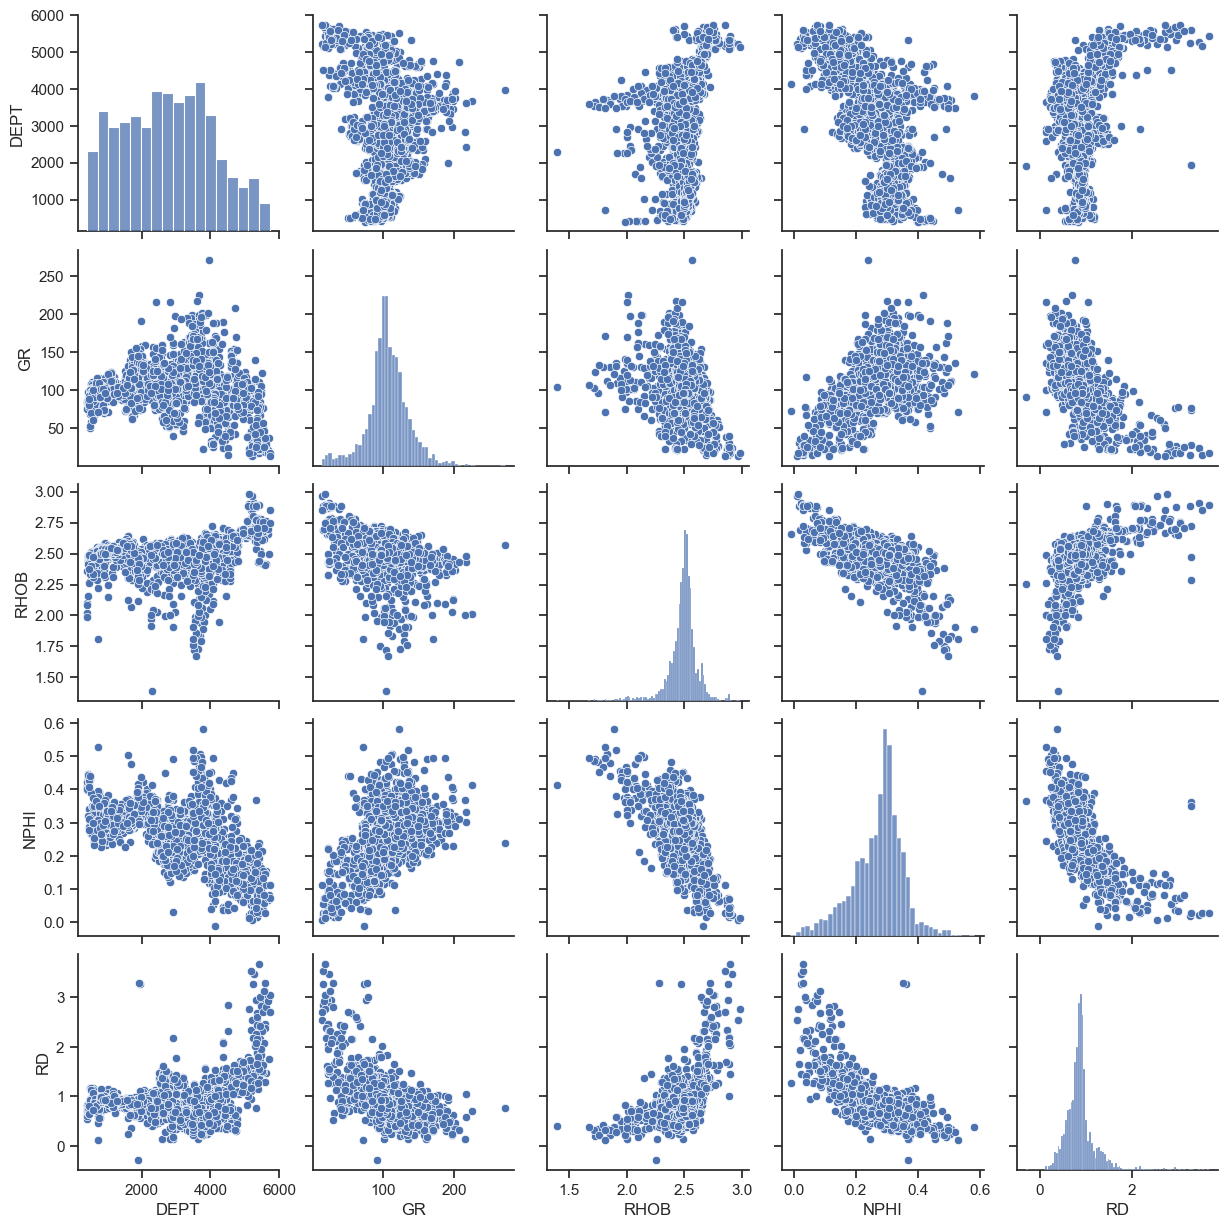

In [9]:
sns.pairplot(Whole_data.sample(2000))

### 이상치 제거

In [17]:
# GR = 200 고정

for i in range(9):
    per_well[i].loc[per_well[i]['GR']>200, 'GR'] = 200


## DTW 분석

In [101]:
alignment = dtw.dtw(query_well, ref_well, step_pattern='asymmetric', keep_internals=True)

<Axes: xlabel='Index', ylabel='Query value'>

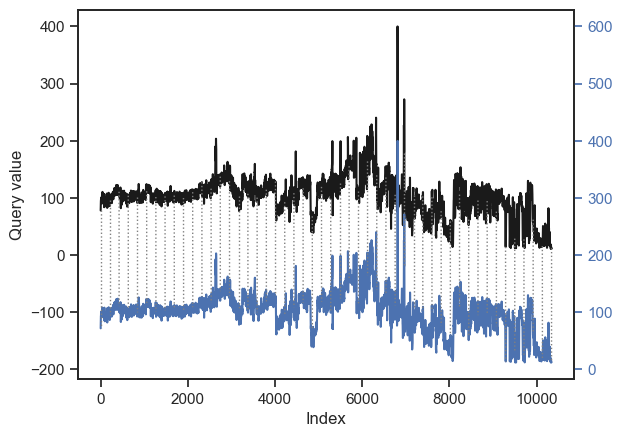

In [102]:
alignment.plot(type='twoway', offset=-200)

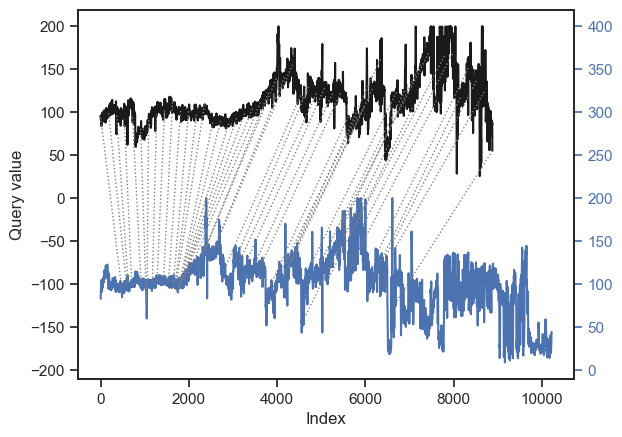

In [30]:
q, r = 0, 8
alignment = dtw.dtw(per_well[q]['GR'], per_well[r]['GR'], step_pattern='asymmetric', keep_internals=True, open_end=True, open_begin=True)
alignment.plot(type='twoway', offset=-200)
plt.savefig('DTW/ref_0/{}_{}.png'.format(q, r))

c:\Users\DELL\anaconda3\envs\SPWLA\lib\site-packages\dtw\dtwPlot.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


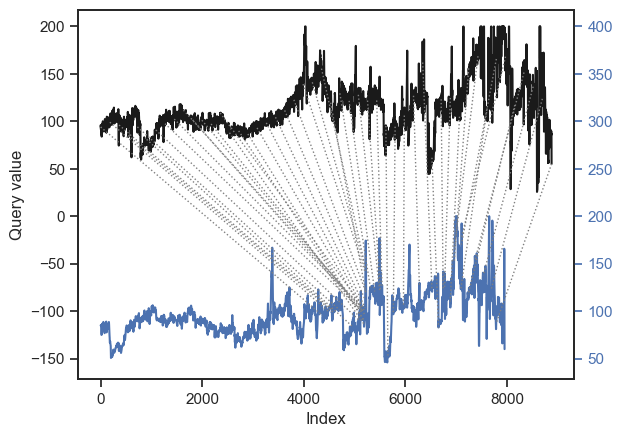

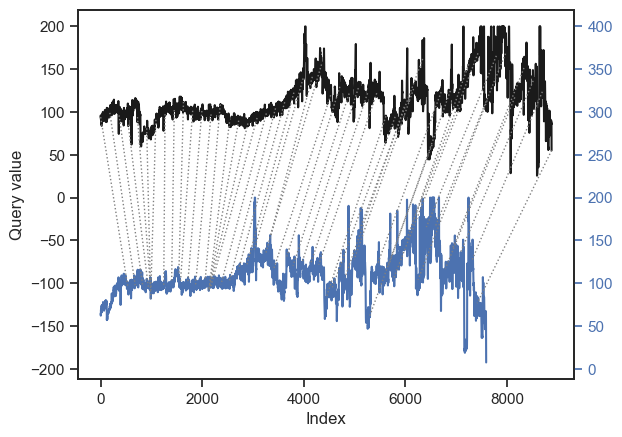

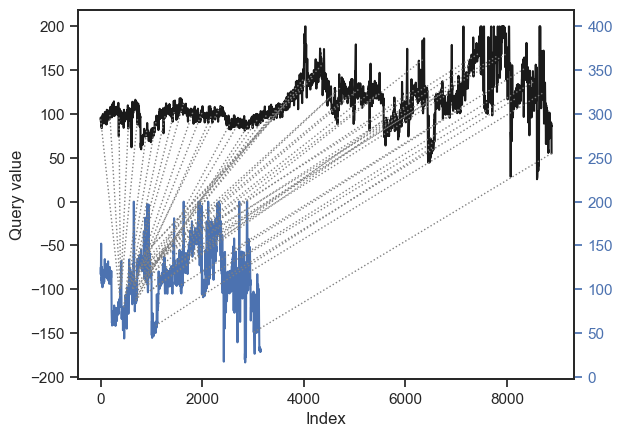

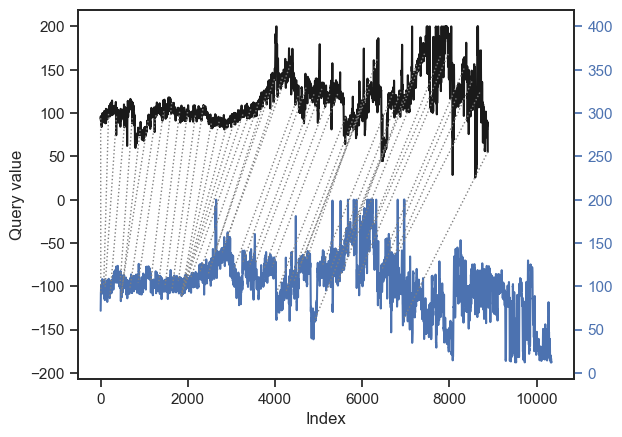

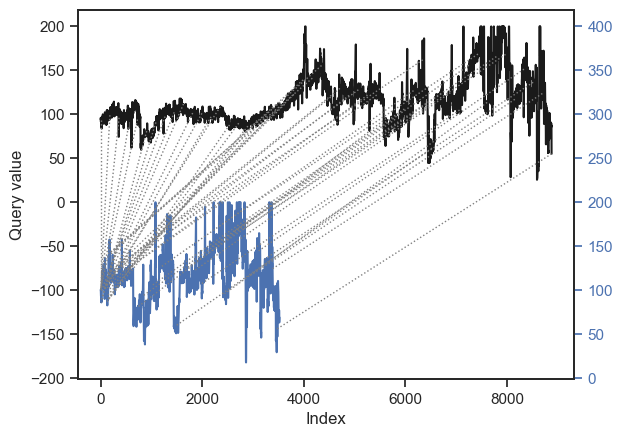

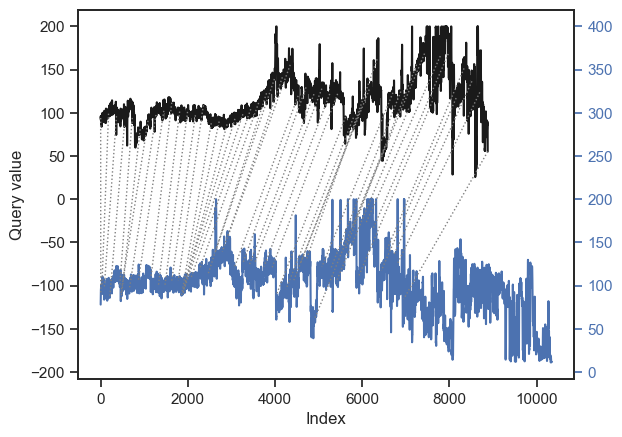

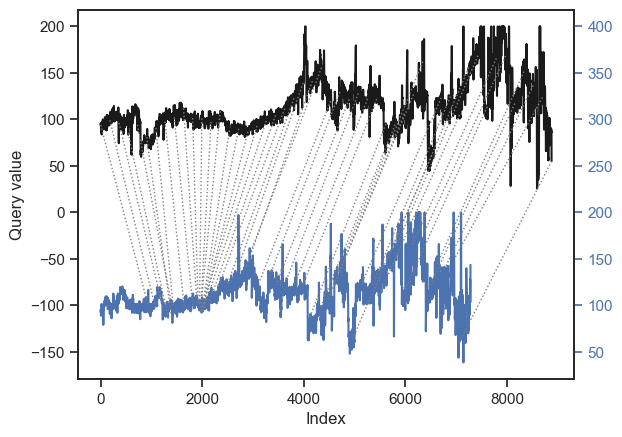

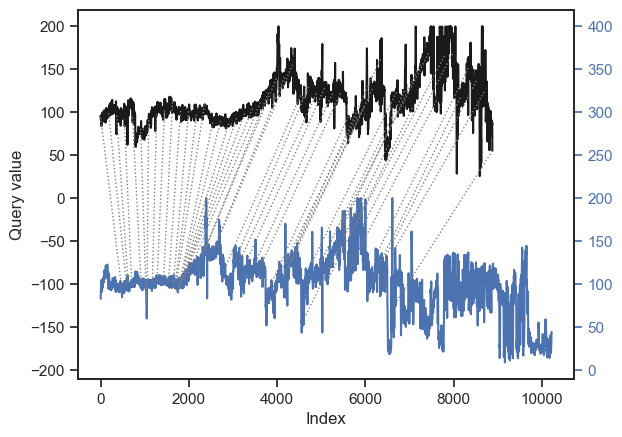

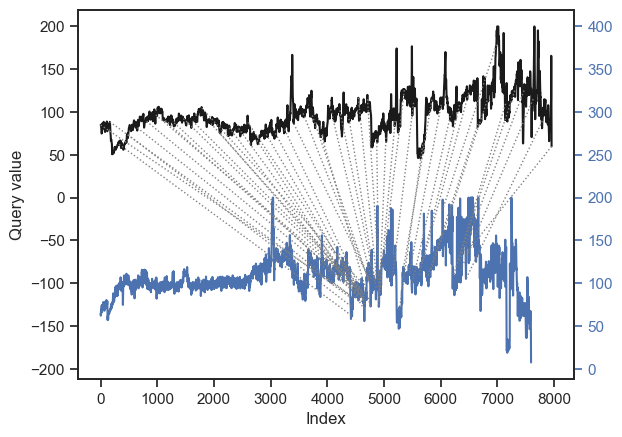

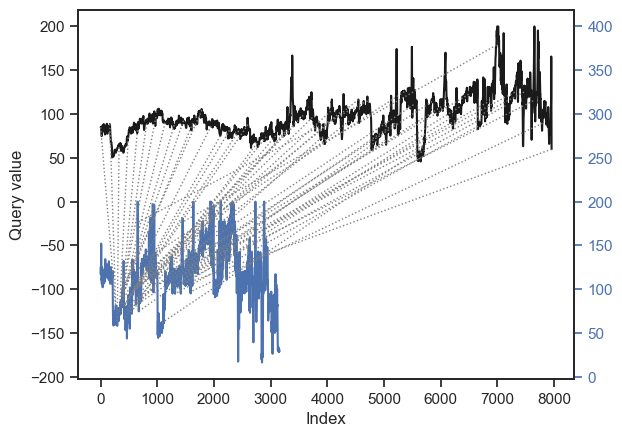

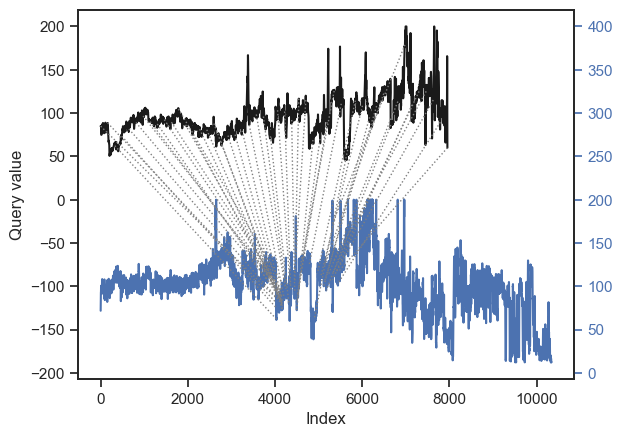

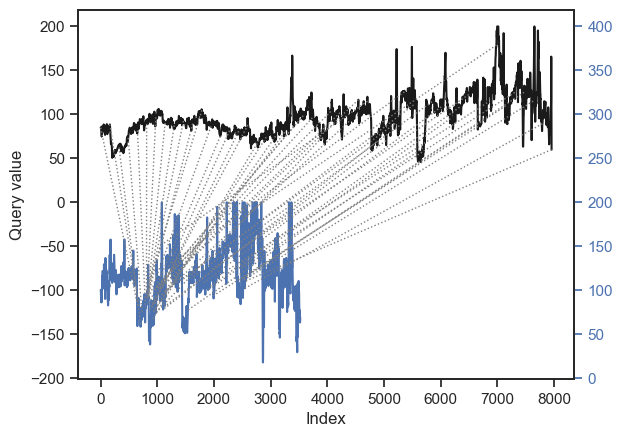

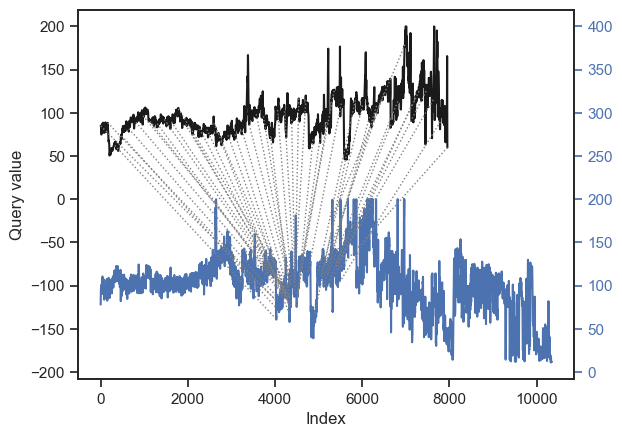

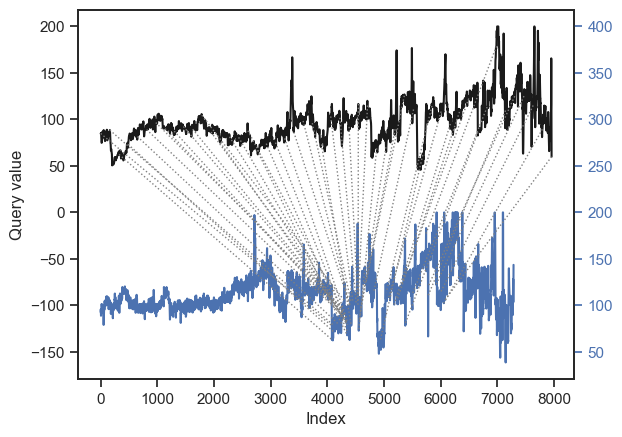

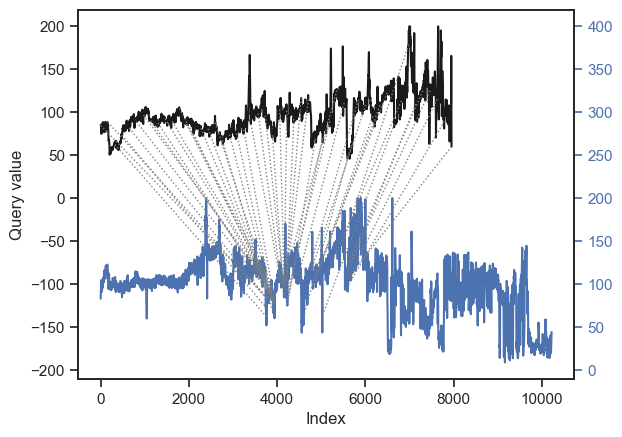

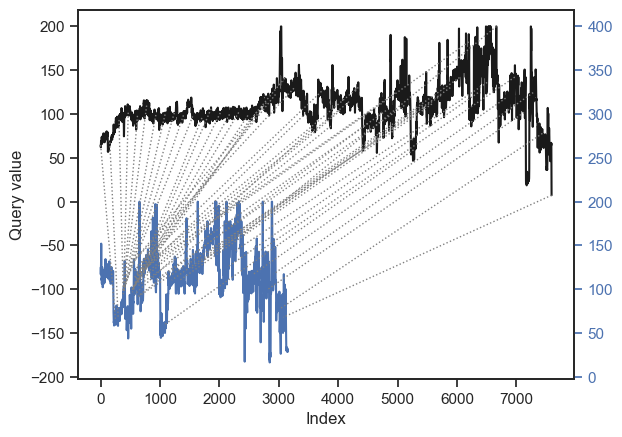

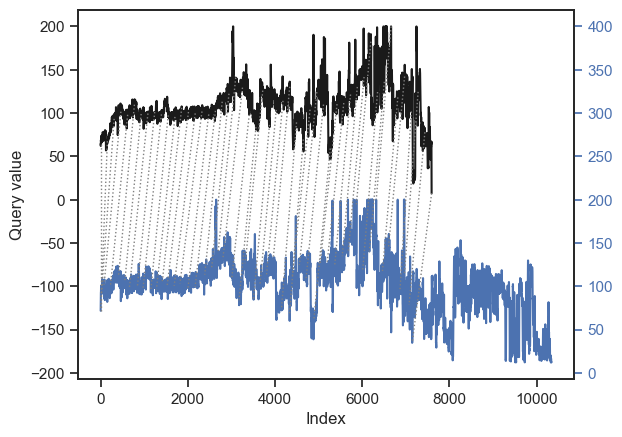

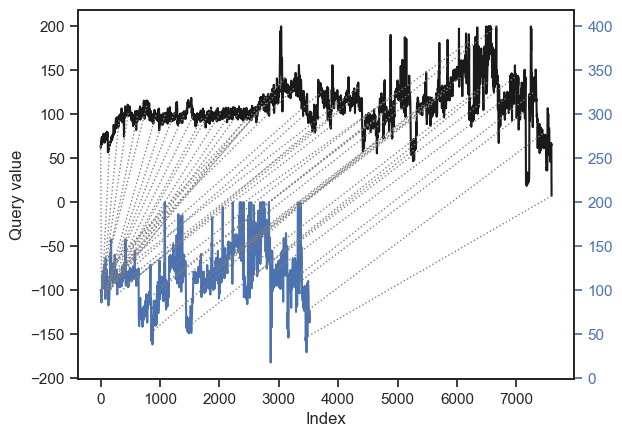

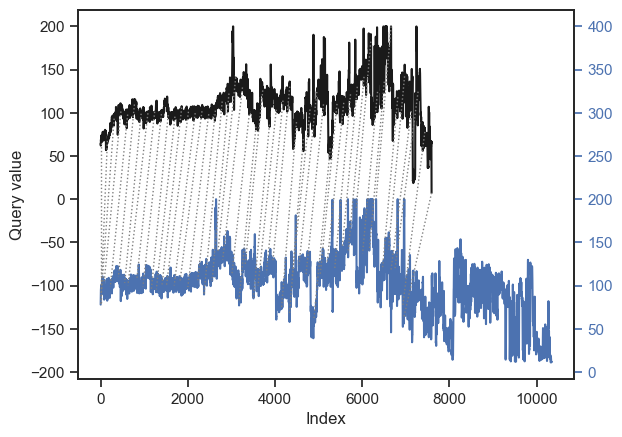

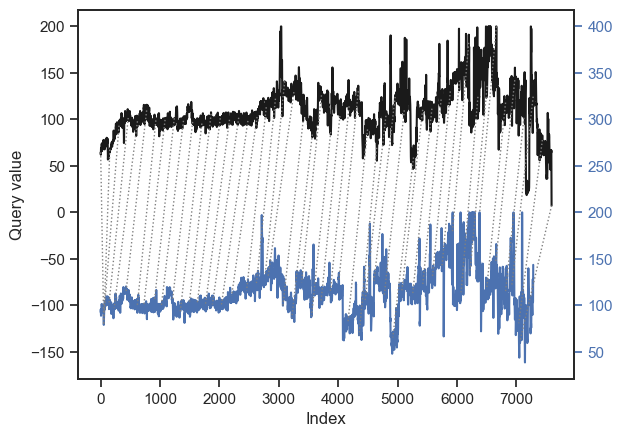

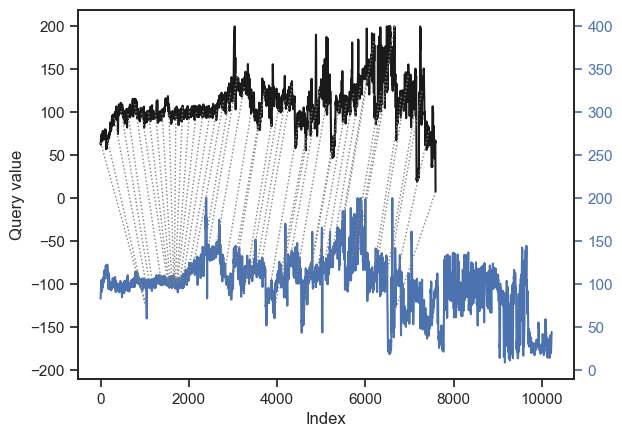

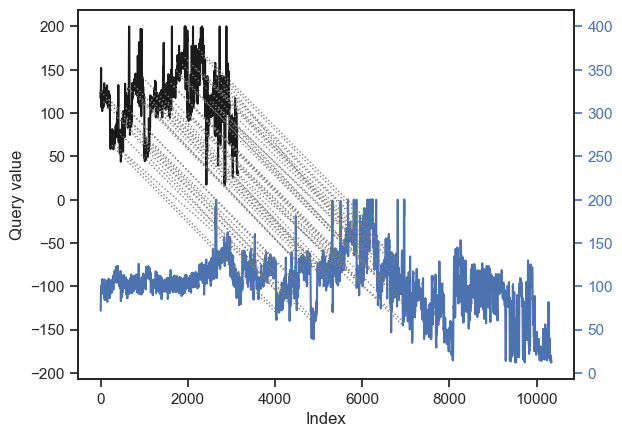

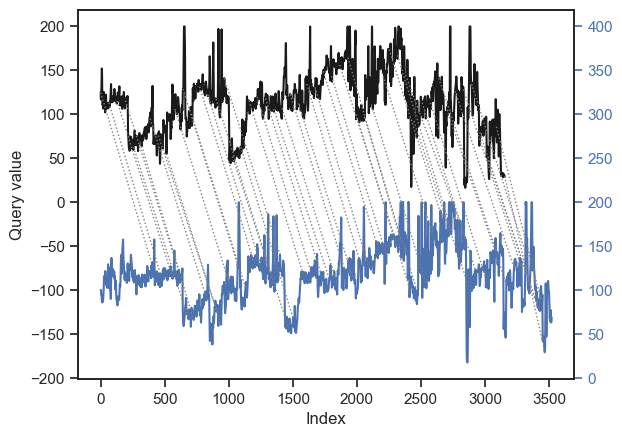

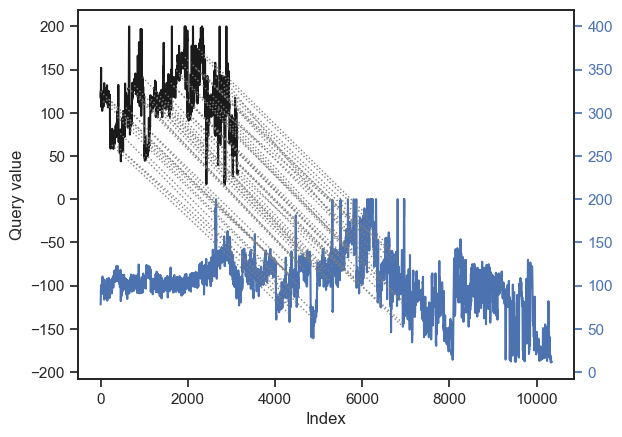

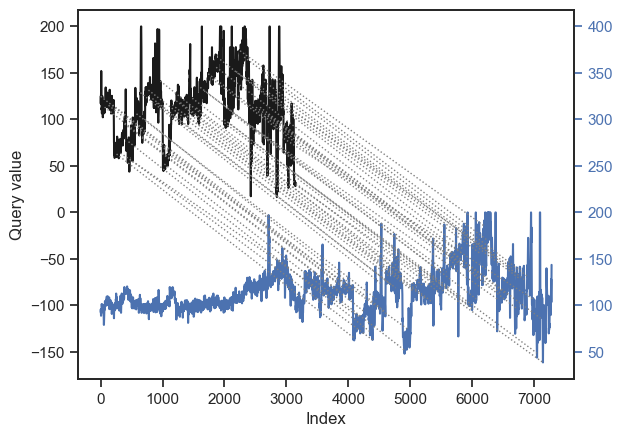

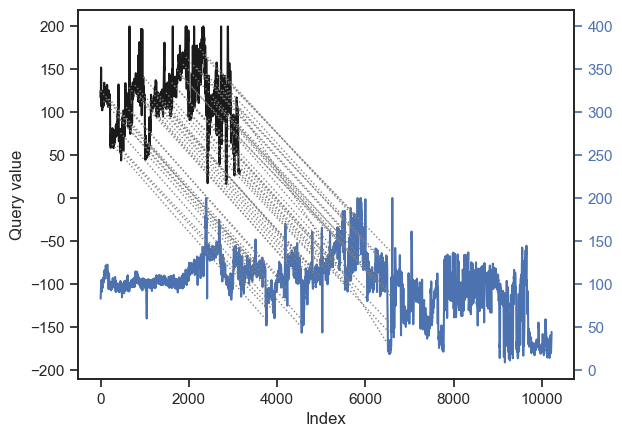

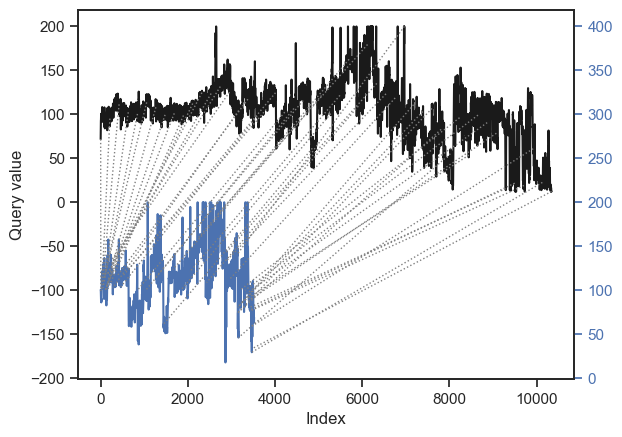

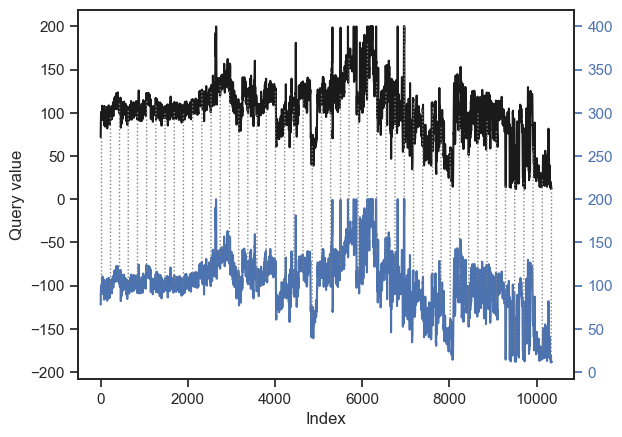

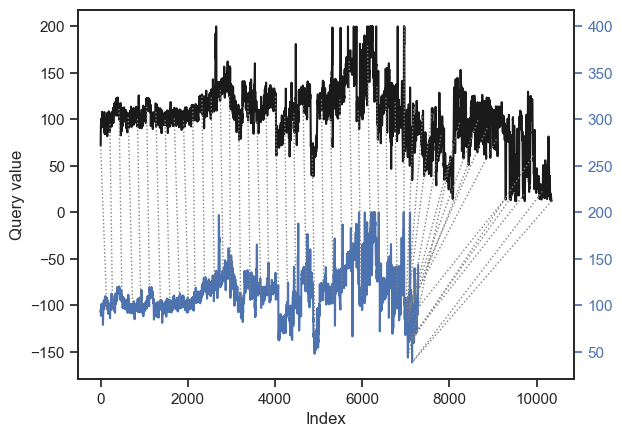

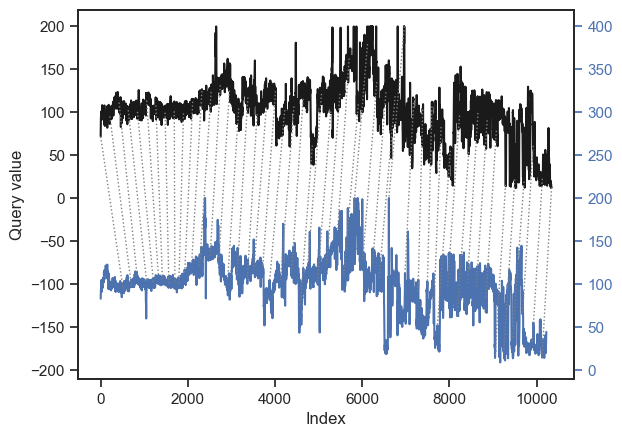

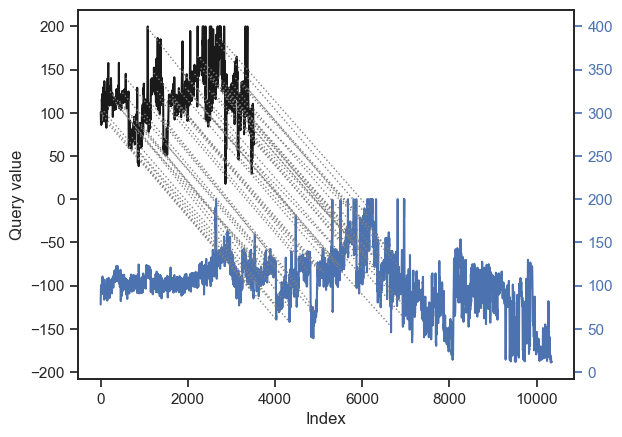

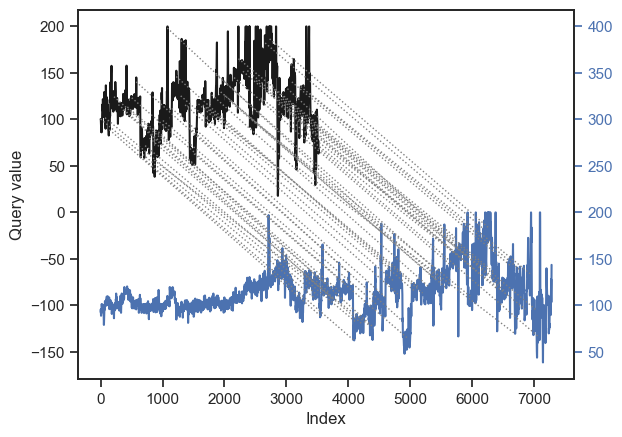

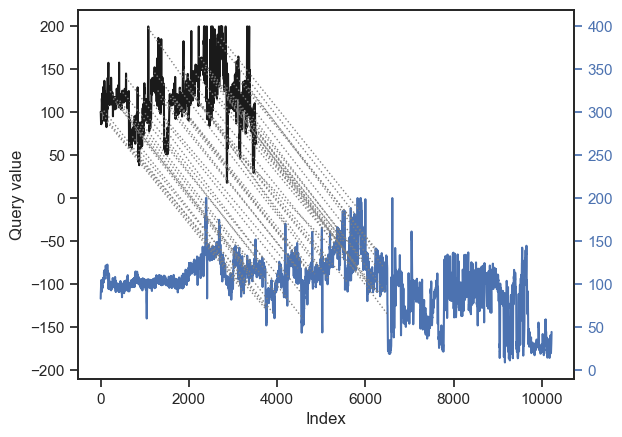

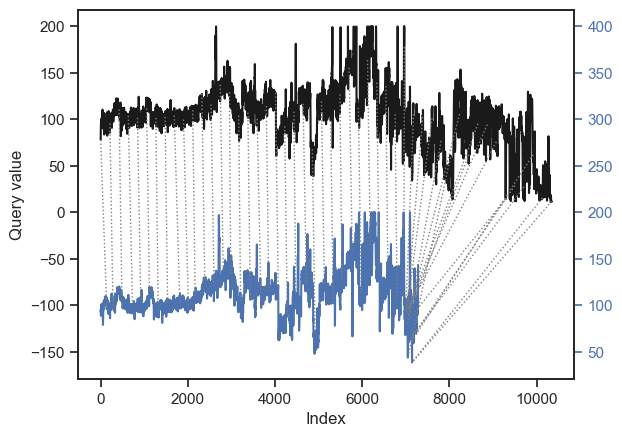

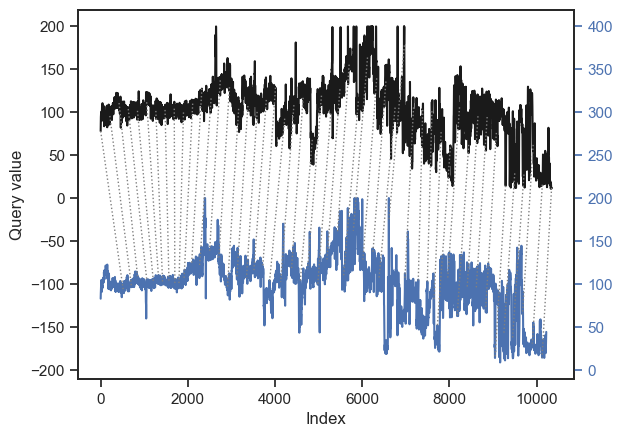

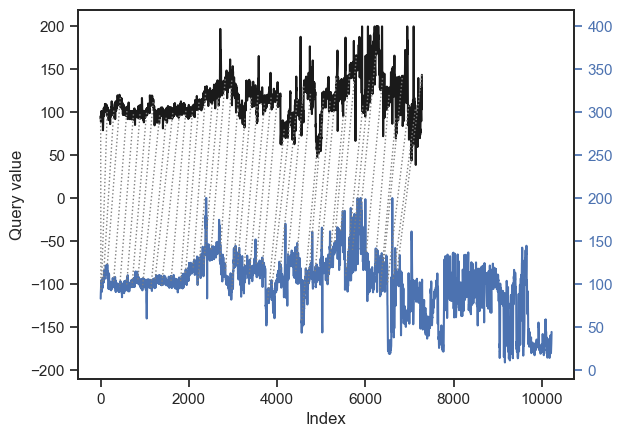

In [18]:
for i in range(9):
    for j in range(9):
        if i >= j:
            continue
        query_well = per_well[i]['GR']
        ref_well = per_well[j]['GR']
        try:
            alignment = dtw.dtw(query_well, ref_well, step_pattern='asymmetric', keep_internals=True, open_end=True, open_begin=True)
            alignment.plot(type='twoway', offset=-200)
            plt.savefig('DTW/open_{}_{}.png'.format(i, j))
        except ValueError:
            alignment = dtw.dtw(ref_well, query_well, step_pattern='asymmetric', keep_internals=True)
            alignment.plot(type='twoway', offset=-200)
            plt.savefig('DTW/open_{}_{}.png'.format(i, j))
        

alignment_OBE = dtw(query_well, ref_well,
    step_pattern='asymmetric',
    window_type='sakoechiba', window_size=500)

<Axes: xlabel='Query index', ylabel='Reference index'>

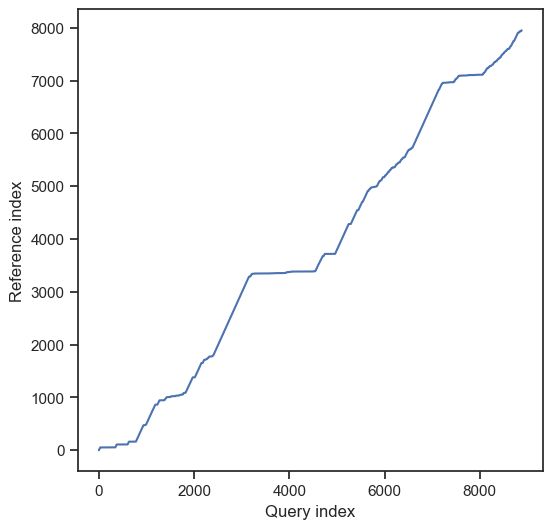

In [47]:
alignment.plot()

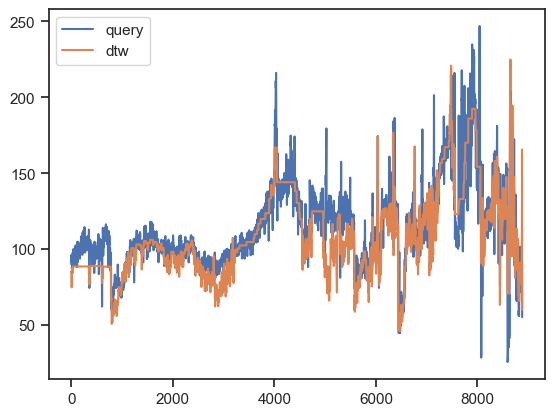

In [48]:
plt.plot(query_well, label='query')
plt.plot(alignment.index1,ref_well[alignment.index2], label='dtw')
plt.legend()

In [ ]:
## DTW 인덱스 엑셀 파일로 추출

a1 = pd.Series(alignment.index1)
a2 = pd.Series(alignment.index2)
a = pd.DataFrame(np.concatenate((alignment.index1.reshape((-1,1)), alignment.index2.reshape((-1,1))), axis=1), columns=['index1', 'index2'])
a.to_excel('dtw_index.xlsx')

### 학습 데이터 분할

In [4]:
# 각 유정 데이터를 하나의 데이터 프레임으로 통합
Whole_data = pd.DataFrame()

for i in range(9):
    Whole_data = Whole_data.append(per_well[i]) 

C:\Users\DELL\AppData\Local\Temp\ipykernel_10048\3944703764.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Whole_data = Whole_data.append(per_well[i])
C:\Users\DELL\AppData\Local\Temp\ipykernel_10048\3944703764.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Whole_data = Whole_data.append(per_well[i])
C:\Users\DELL\AppData\Local\Temp\ipykernel_10048\3944703764.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Whole_data = Whole_data.append(per_well[i])
C:\Users\DELL\AppData\Local\Temp\ipykernel_10048\3944703764.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Whole_data = Whole_data.append(per_well[i])
C:\Users\DELL\AppDat

In [57]:
Whole_data = per_well[0]

In [58]:
# 전기비저항 검층 로그화
Whole_data['RD'] = np.log10(Whole_data['RD'])

In [59]:
Train_data, Val_data = train_test_split(Whole_data, test_size = .2)

In [60]:
Feature_name = ['RHOB','NPHI','RD']
x_train, y_train = Train_data['GR'], Train_data[Feature_name]
x_val, y_val = Val_data['GR'], Val_data[Feature_name]

In [61]:
x_train = np.array(x_train).reshape(-1,1)
y_train = np.array(y_train).reshape(-1,3)

In [62]:
x_val = np.array(x_val).reshape(-1,1)
y_val = np.array(y_val).reshape(-1,3)

### 학습 데이터 전처리

### 모델 선정 및 학습

In [17]:
rf_reg = RandomForestRegressor()
xg_reg = xgboost.XGBRFRegressor()

In [18]:
rf_reg.fit(x_train, y_train)

RandomForestRegressor()

In [19]:
xg_reg.fit(x_train, y_train)

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               objective='reg:squarederror', predictor=None, random_state=None,
               reg_alpha=None, ...)

In [26]:
# lightGBM, SVR 학습
y_train_pred_light = np.zeros((len(x_train), 3))
y_val_pred_light = np.zeros((len(x_val), 3))
y_train_pred_svm = np.zeros((len(x_train), 3))
y_val_pred_svm = np.zeros((len(x_val), 3))
r2_light = []
r2_light_val = []
r2_svm = []
r2_svm_val = []

for i in range(3):
    d_train = lightgbm.Dataset(x_train, label=y_train[:,i])
    params = {}
    params['learning_rate'] = 0.003
    params['boosting_type'] = 'gbdt'
    # params['objective'] = 'binary'
    params['metric'] = 'MSE'
    # params['sub_feature'] = 0.5
    # params['num_leaves'] = 10
    # params['min_data'] = 50
    # params['max_depth'] = 10
    light_reg = lightgbm.train(params, d_train, 100)

    light_pred = light_reg.predict(x_train)
    y_train_pred_light[:,i] = light_pred

    light_pred2 = light_reg.predict(x_val)
    y_val_pred_light[:,i] = light_pred2

    r2_light.append(r2_score(y_train[:,i], light_pred))
    r2_light_val.append(r2_score(y_val[:,i], light_pred2))

    svm_reg = SVR()
    svm_reg.fit(x_train, y_train[:,i])
    svm_pred = svm_reg.predict(x_train)
    svm_pred2 = svm_reg.predict(x_val)
    y_train_pred_svm[:,i] = svm_pred
    y_val_pred_svm[:,i] = svm_pred2
    r2_svm.append(r2_score(y_train[:,i], svm_pred))
    r2_svm_val.append(r2_score(y_val[:,i], svm_pred2))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 55443, number of used features: 1
[LightGBM] [Info] Start training from score 2.490061
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 55443, number of used features: 1
[LightGBM] [Info] Start training from score 0.267299
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train

In [166]:
d_train = lightgbm.Dataset(x_train, label=y_train[:,0])
params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 10
model = lightgbm.train(params, d_train, 100)


[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 55443, number of negative: 0
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 55443, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGB

In [167]:
svm_reg.fit(x_train, y_train[:,0])

SVR()

In [27]:
r2_rf = []
r2_rf_val = []
r2_xg = []
r2_xg_val = []

y_train_pred_rf = rf_reg.predict(x_train)
y_val_pred_rf = rf_reg.predict(x_val)
y_train_pred_xg = xg_reg.predict(x_train)
y_val_pred_xg = xg_reg.predict(x_val)


for i in range(3):
    r2_rf.append(r2_score(y_train[:, i], y_train_pred_rf[:, i]))
    r2_rf_val.append(r2_score(y_val[:, i], y_val_pred_rf[:, i]))
    r2_xg.append(r2_score(y_train[:, i], y_train_pred_xg[:, i]))
    r2_xg_val.append(r2_score(y_val[:, i], y_val_pred_xg[:, i]))

In [182]:
y_train_pred_svm = svm_reg.predict(x_train)

In [184]:
y_train_pred_light = model.predict(x_train)

### 학습 결과 플랏

In [18]:
solid_line = np.arange(math.floor(y_train[:,1].min()), math.ceil(y_train[:,1].max()))
solid_line, math.floor(y_train[:,1].min()), 

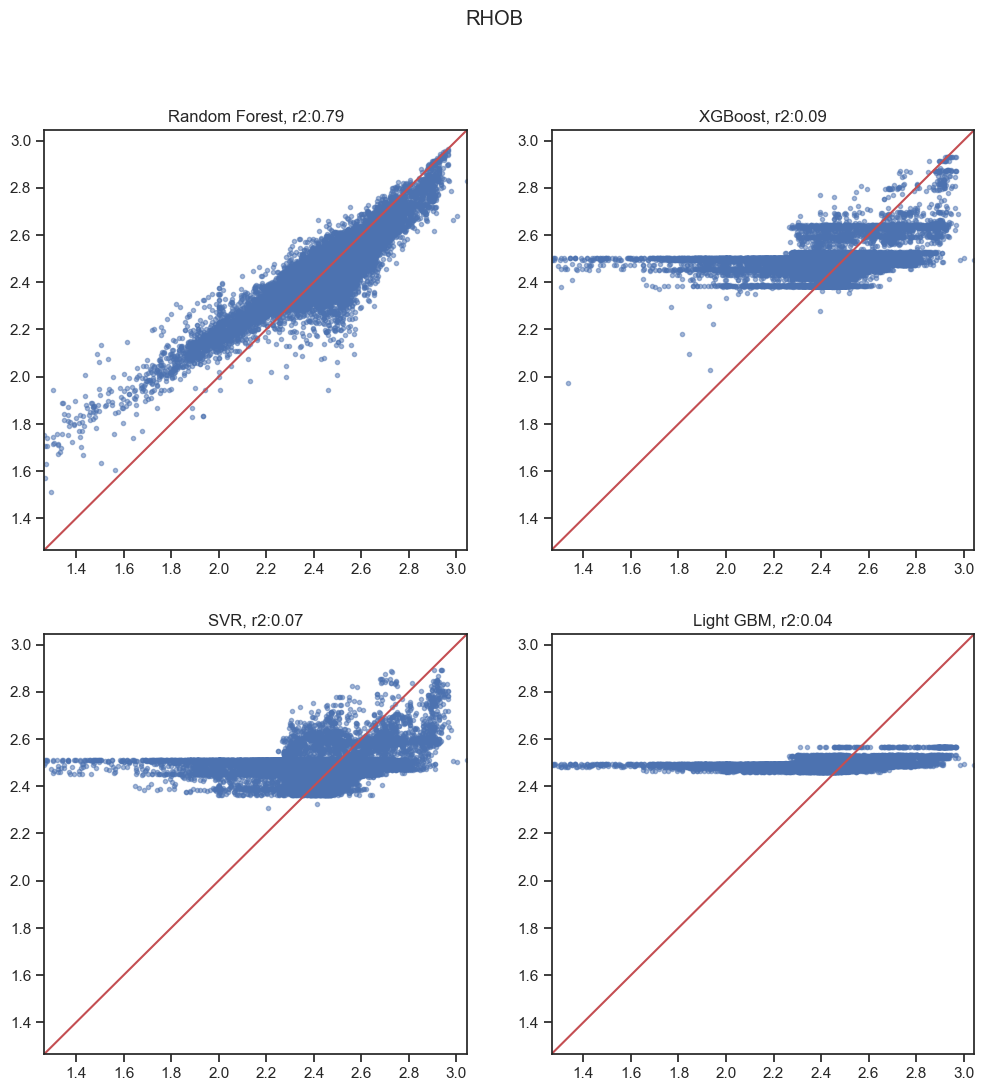

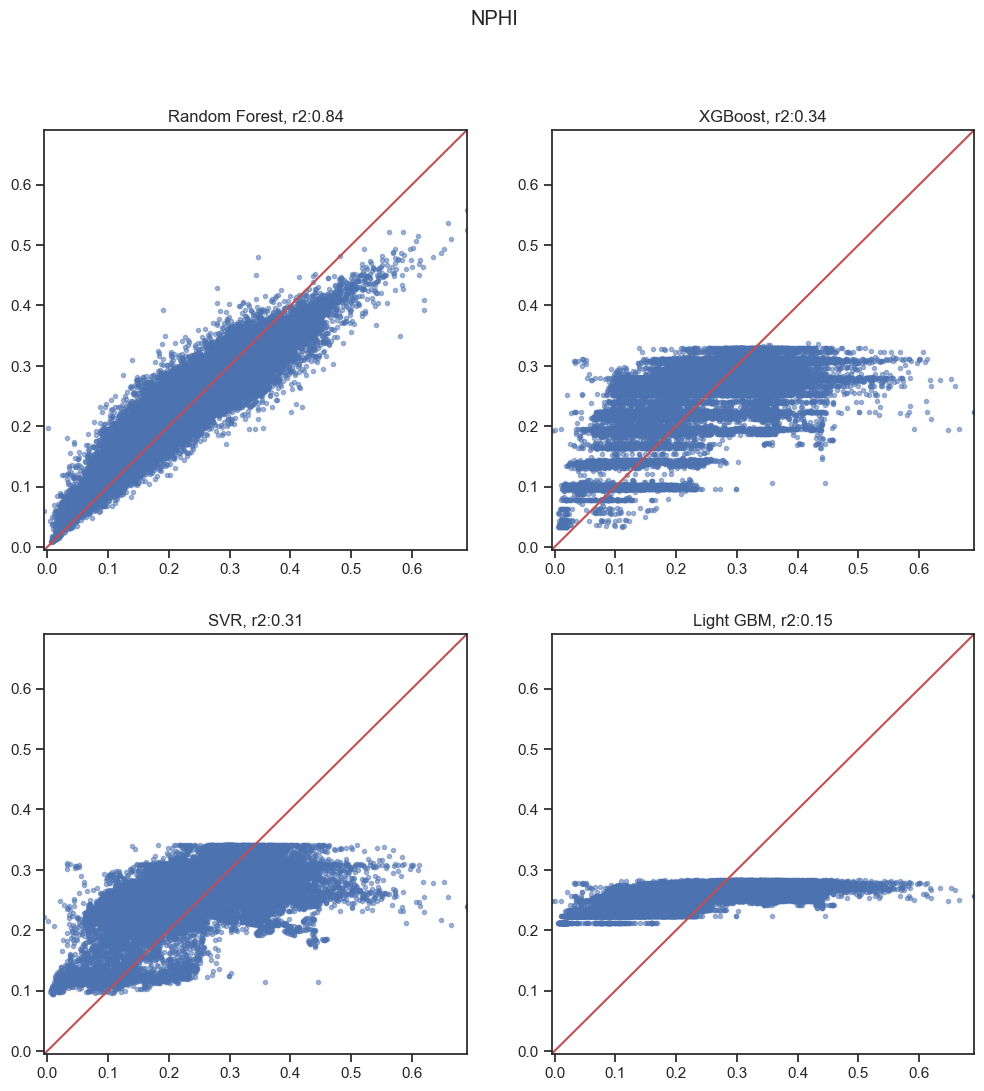

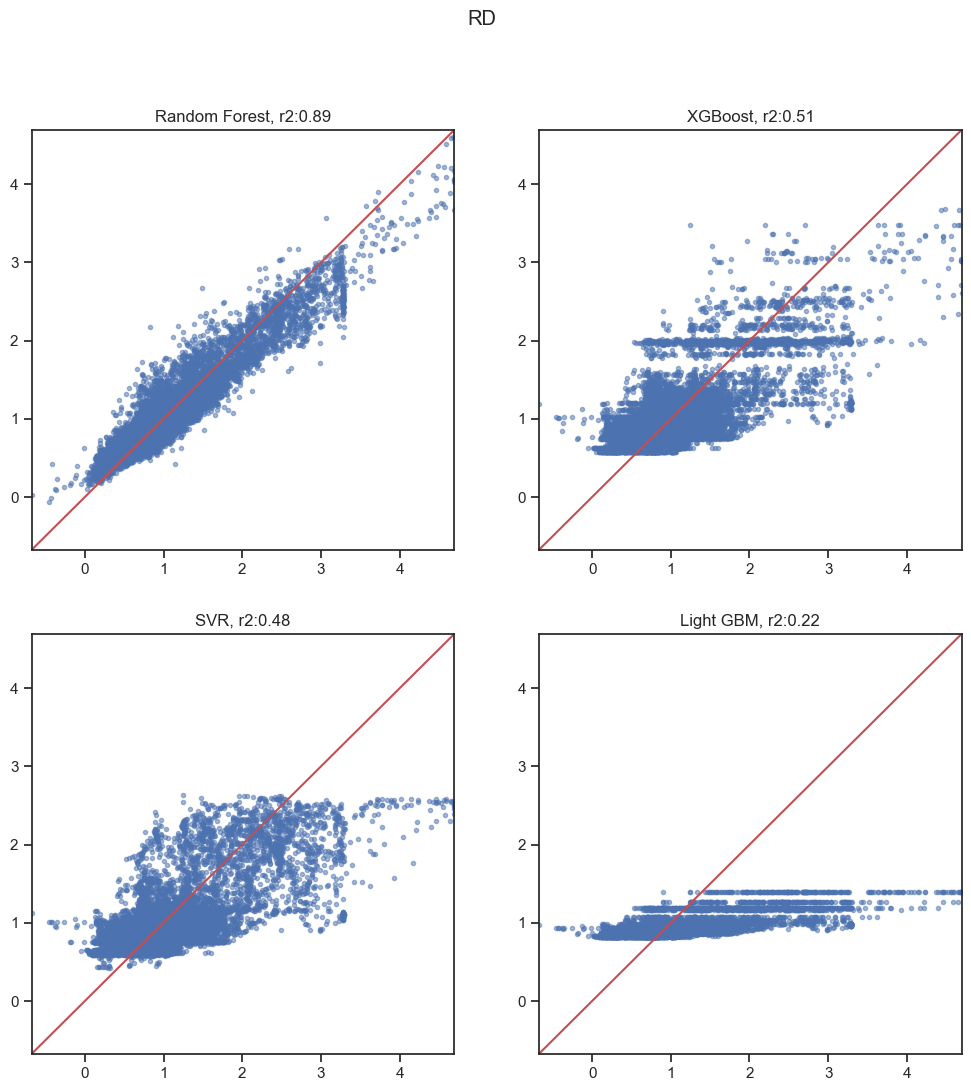

In [22]:
for i in range(3):
    x_min, x_max = y_train[:,i].min(), y_train[:,i].max()
    solid_line = [x_min, x_max]

    plt.figure(figsize=(12,12))

    plt.suptitle('{}'.format(Feature_name[i]))

    plt.subplot(221)
    plt.plot(y_train[:,i], y_train_pred_rf[:,i], '.', alpha=0.5)
    plt.plot(solid_line, solid_line, c='r')
    plt.xlim(x_min, x_max)
    plt.ylim(x_min, x_max)
    plt.title('Random Forest, r2:{:.2f}'.format(r2_rf[i]))

    plt.subplot(222)
    plt.plot(y_train[:,i], y_train_pred_xg[:,i], '.', alpha=0.5)
    plt.plot(solid_line, solid_line, c='r')
    plt.xlim(x_min, x_max)
    plt.ylim(x_min, x_max)
    plt.title('XGBoost, r2:{:.2f}'.format(r2_xg[i]))

    plt.subplot(223)
    plt.plot(y_train[:,i], y_train_pred_svm[:, i], '.', alpha=0.5)
    plt.plot(solid_line, solid_line, c='r')
    plt.xlim(x_min, x_max)
    plt.ylim(x_min, x_max)
    plt.title('SVR, r2:{:.2f}'.format(r2_svm[i]))

    plt.subplot(224)
    plt.plot(y_train[:, i], y_train_pred_light[:, i], '.', alpha=0.5)
    plt.plot(solid_line, solid_line, c='r')
    plt.xlim(x_min, x_max)
    plt.ylim(x_min, x_max)
    plt.title('Light GBM, r2:{:.2f}'.format(r2_light[i]))

In [29]:
r2_rf_val, r2_rf

([-0.3243837660743054, 0.01803639067467444, 0.2773859379766408],
 [0.7898684755703305, 0.837738051827547, 0.8853131329024121])

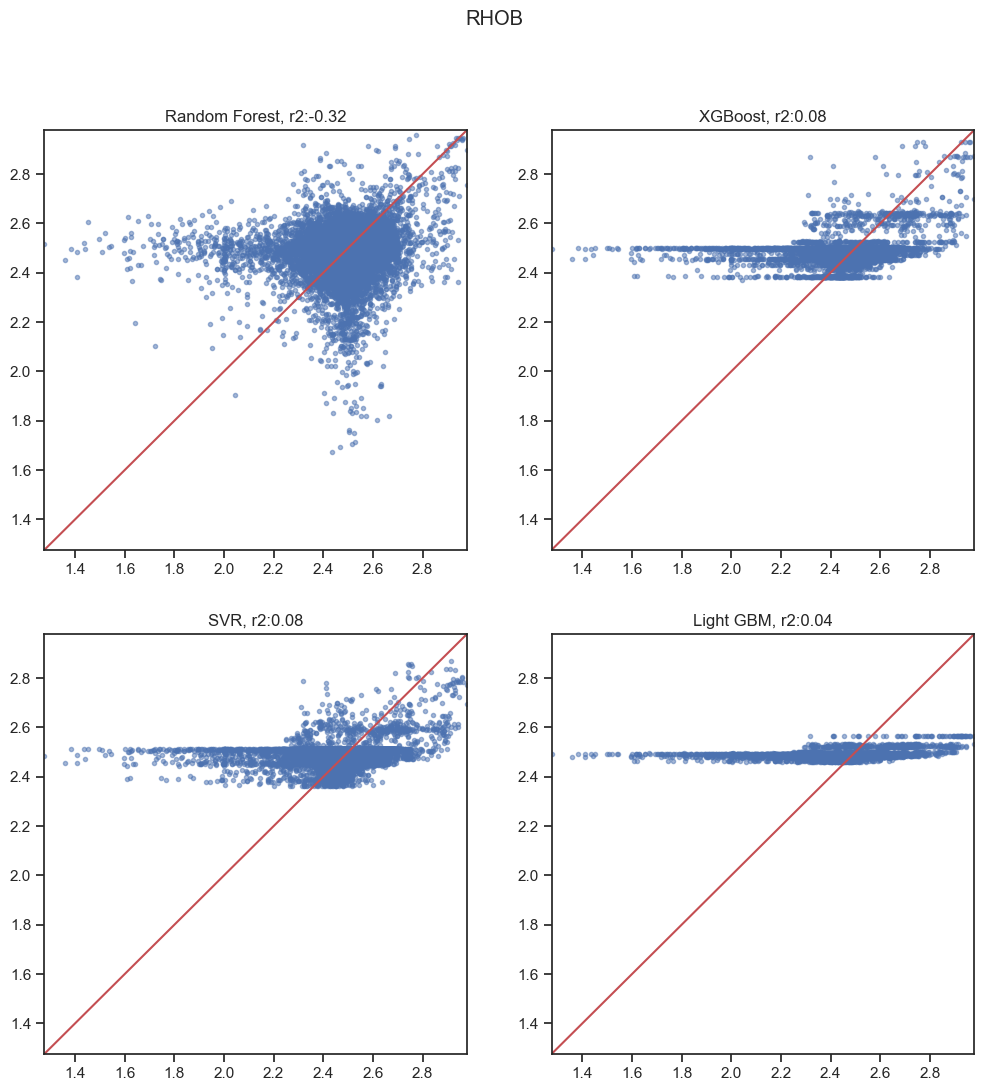

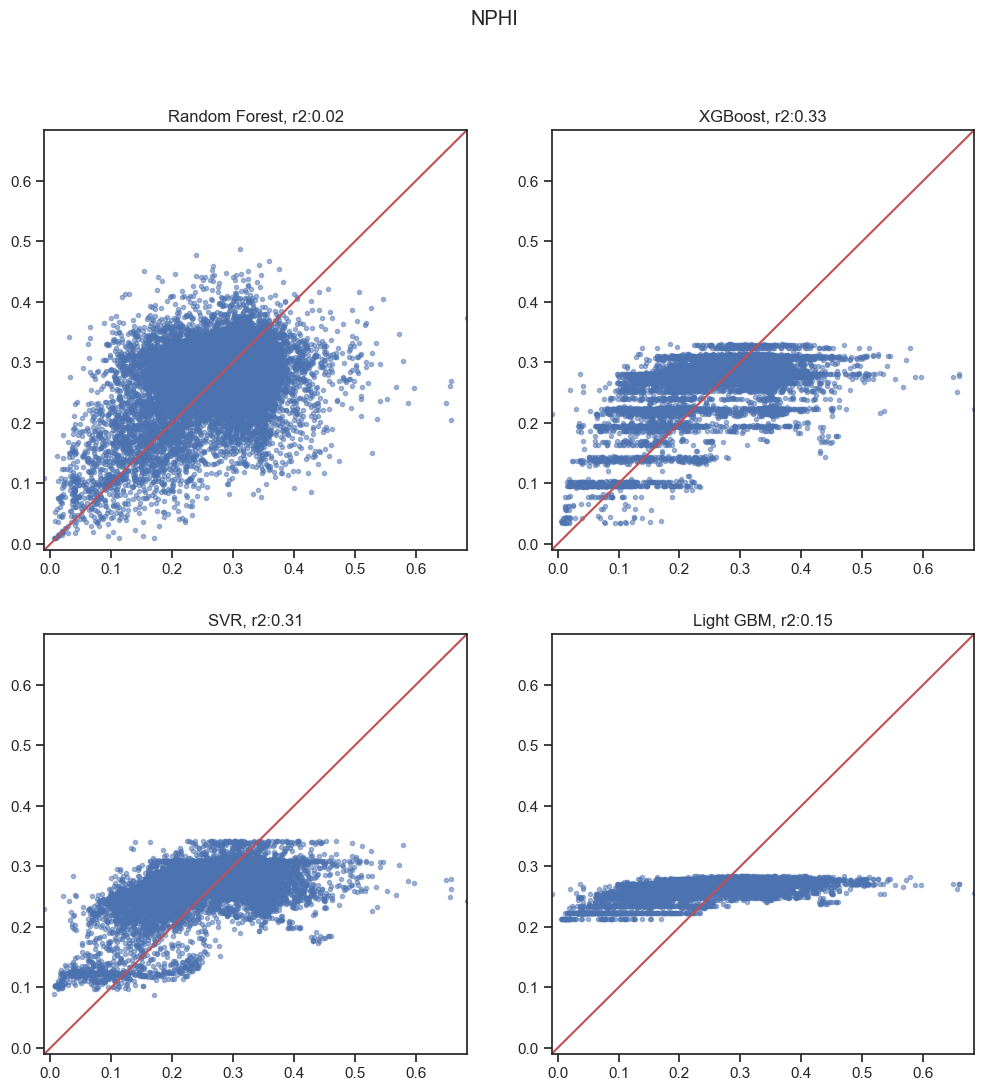

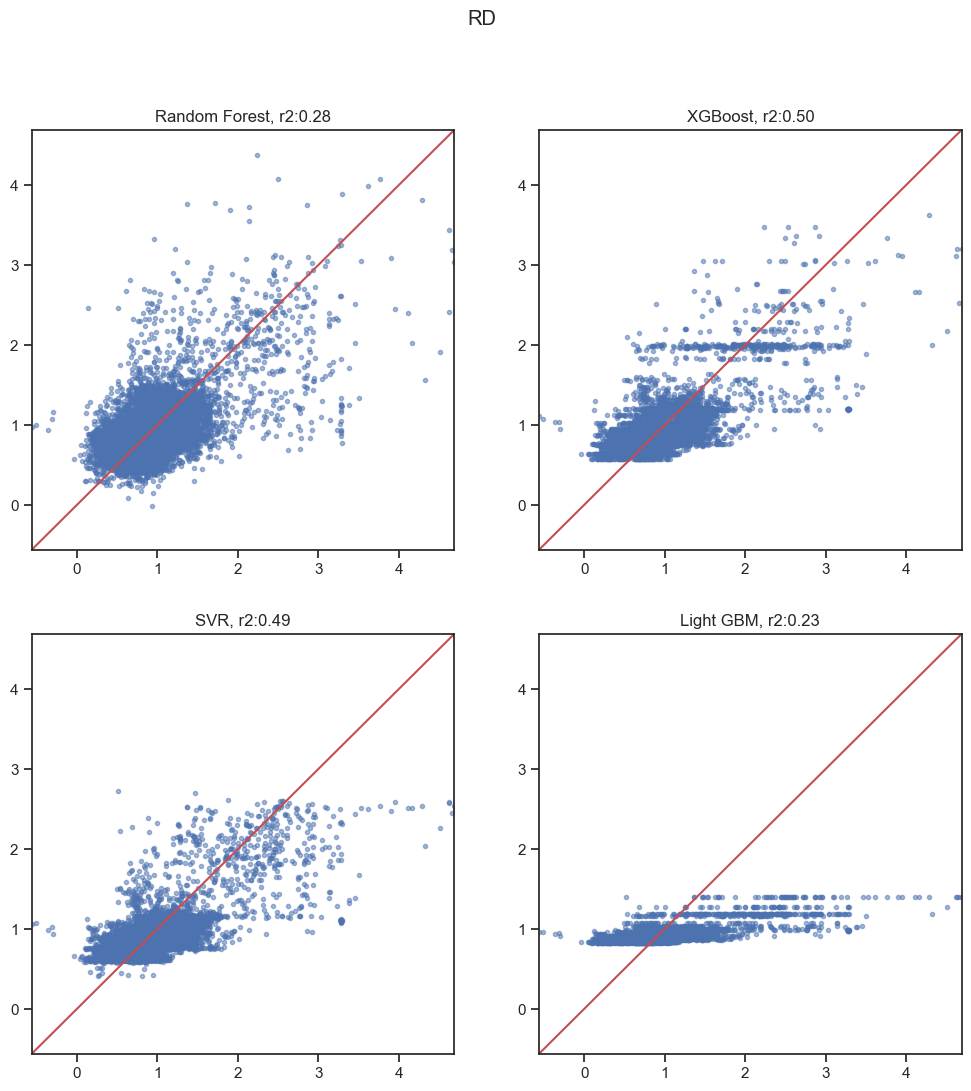

In [30]:
for i in range(3):
    x_min, x_max = y_val[:,i].min(), y_val[:,i].max()
    solid_line = [x_min, x_max]

    plt.figure(figsize=(12,12))

    plt.suptitle('{}'.format(Feature_name[i]))

    plt.subplot(221)
    plt.plot(y_val[:,i], y_val_pred_rf[:,i], '.', alpha=0.5)
    plt.plot(solid_line, solid_line, c='r')
    plt.xlim(x_min, x_max)
    plt.ylim(x_min, x_max)
    plt.title('Random Forest, r2:{:.2f}'.format(r2_rf_val[i]))

    plt.subplot(222)
    plt.plot(y_val[:,i], y_val_pred_xg[:,i], '.', alpha=0.5)
    plt.plot(solid_line, solid_line, c='r')
    plt.xlim(x_min, x_max)
    plt.ylim(x_min, x_max)
    plt.title('XGBoost, r2:{:.2f}'.format(r2_xg_val[i]))

    plt.subplot(223)
    plt.plot(y_val[:,i], y_val_pred_svm[:, i], '.', alpha=0.5)
    plt.plot(solid_line, solid_line, c='r')
    plt.xlim(x_min, x_max)
    plt.ylim(x_min, x_max)
    plt.title('SVR, r2:{:.2f}'.format(r2_svm_val[i]))

    plt.subplot(224)
    plt.plot(y_val[:, i], y_val_pred_light[:, i], '.', alpha=0.5)
    plt.plot(solid_line, solid_line, c='r')
    plt.xlim(x_min, x_max)
    plt.ylim(x_min, x_max)
    plt.title('Light GBM, r2:{:.2f}'.format(r2_light_val[i]))

### 파이프라인 구축

In [ ]:
# 파이프라인 구축
rf_reg = RandomForestRegressor()
xg_reg = xgboost.XGBRFRegressor()
light_reg = lightgbm.LGBMRegressor()
svm_reg = SVR()

pipeline = Pipeline([
    ('rf_reg', rf_reg),
    ('xg_reg', xg_reg),
    ('light_reg', light_reg),
    ('svm_reg', svm_reg)
])

### 실험실

In [13]:
# Median filter
window_size = 200
window = []
for i in range(len(per_well[0]['GR'])):
    if i < window_size//2 :
        window.append(np.median(per_well[0]['GR'][:i]))
    elif i > len(per_well[0]) - window_size//2 :
        window.append(np.median(per_well[0]['GR'][i-window_size//2:-1]))
    else:
        window.append(np.median(per_well[0]['GR'][i-window_size//2:i+window_size//2]))

c:\Users\DELL\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\DELL\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


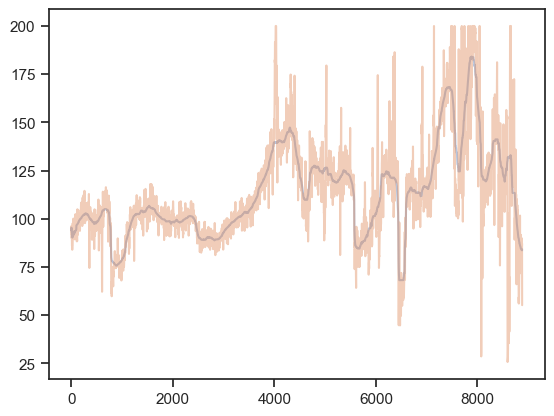

In [14]:
plt.plot(window, alpha=0.4)
plt.plot(per_well[0]['GR'], alpha=0.4)

In [19]:
# Zone 구분 할 때, 학습 결과
Data = pd.read_excel('Median.xlsx')
Data['RD'] = np.log10(Data['RD'])

In [20]:
Data_n = Data.loc[Data['Zone']==-1]
Data_0 = Data.loc[Data['Zone']==0]
Data_p = Data.loc[Data['Zone']==1]

In [21]:
train_x_n, val_x_n = train_test_split(Data_n, test_size=0.2)
train_x_0, val_x_0 = train_test_split(Data_0, test_size=0.2)
train_x_p, val_x_p = train_test_split(Data_p, test_size=0.2)

In [22]:
Feature_name = ['RHOB','NPHI','RD']
train_x_n, train_y_n = train_x_n['GR'], train_x_n[Feature_name]
val_x_n, val_y_n = val_x_n['GR'], val_x_n[Feature_name]

train_x_0, train_y_0 = train_x_0['GR'], train_x_0[Feature_name]
val_x_0, val_y_0 = val_x_0['GR'], val_x_0[Feature_name]

train_x_p, train_y_p = train_x_p['GR'], train_x_p[Feature_name]
val_x_p, val_y_p = val_x_p['GR'], val_x_p[Feature_name]

In [33]:
train_x_n = np.array(train_x_n).reshape(-1,1)
train_y_n = np.array(train_y_n).reshape(-1,3)

train_x_0 = np.array(train_x_0).reshape(-1,1)
train_y_0 = np.array(train_y_0).reshape(-1,3)

train_x_p = np.array(train_x_p).reshape(-1,1)
train_y_p = np.array(train_y_p).reshape(-1,3)

val_x_n = np.array(val_x_n).reshape(-1,1)
val_y_n = np.array(val_y_n).reshape(-1,3)

val_x_0 = np.array(val_x_0).reshape(-1,1)
val_y_0 = np.array(val_y_0).reshape(-1,3)

val_x_p = np.array(val_x_p).reshape(-1,1)
val_y_p = np.array(val_y_p).reshape(-1,3)

In [37]:
train_y = np.zeros((1,3))

for i in [train_y_n, train_y_0, train_y_p]:
    train_y = np.concatenate((train_y, i), axis=0)
train_y = np.delete(train_y, 0, axis=0)

val_y = np.zeros((1,3))

for i in [val_y_n, val_y_0, val_y_p]:
    val_y = np.concatenate((val_y, i), axis=0)
val_y = np.delete(val_y, 0, axis=0)

In [53]:
rf_reg2 = RandomForestRegressor()
xg_reg2 = xgboost.XGBRegressor()
lin_reg = LinearRegression()

train_y_pred_rf = np.zeros((1, 3))
train_y_pred_xg = np.zeros((1, 3))
train_y_pred_lin = np.zeros((1, 3))
val_y_pred_rf = np.zeros((1, 3))
val_y_pred_xg = np.zeros((1, 3))
val_y_pred_lin = np.zeros((1, 3))
for i, j, k in [[train_x_n,train_y_n, val_x_n],[train_x_0,train_y_0, val_x_0],[train_x_p,train_y_p, val_x_p]]:
    rf_reg2.fit(i, j)
    xg_reg2.fit(i, j)
    lin_reg.fit(i, j)

    train_y_pred_rf = np.concatenate((train_y_pred_rf, rf_reg2.predict(i)), axis=0)
    train_y_pred_xg = np.concatenate((train_y_pred_xg, xg_reg2.predict(i)), axis=0)
    train_y_pred_lin = np.concatenate((train_y_pred_lin, lin_reg.predict(i)), axis=0)
    val_y_pred_rf = np.concatenate((val_y_pred_rf, rf_reg2.predict(k)), axis=0)
    val_y_pred_xg = np.concatenate((val_y_pred_xg, xg_reg2.predict(k)), axis=0)
    val_y_pred_lin = np.concatenate((val_y_pred_lin, lin_reg.predict(k)), axis=0)
train_y_pred_rf = np.delete(train_y_pred_rf, 0, axis=0)
train_y_pred_xg = np.delete(train_y_pred_xg, 0, axis=0)
train_y_pred_lin = np.delete(train_y_pred_lin, 0, axis=0)
val_y_pred_rf = np.delete(val_y_pred_rf, 0, axis=0)
val_y_pred_xg = np.delete(val_y_pred_xg, 0, axis=0)
val_y_pred_lin = np.delete(val_y_pred_lin, 0, axis=0)

In [54]:
r2_rf2 = []
r2_xg2 = []
for i in range(3):
    r2_rf2.append(r2_score(train_y[:, i], train_y_pred_rf[:, i]))
    r2_xg2.append(r2_score(train_y[:, i], train_y_pred_xg[:, i]))

r2_rf3 = []
r2_xg3 = []
for i in range(3):
    r2_rf3.append(r2_score(val_y[:, i], val_y_pred_rf[:, i]))
    r2_xg3.append(r2_score(val_y[:, i], val_y_pred_xg[:, i]))

r2_lin = []
r2_lin2 = []
for i in range(3):
    r2_lin.append(r2_score(train_y[:, i], train_y_pred_lin[:, i]))
    r2_lin2.append(r2_score(val_y[:, i], val_y_pred_lin[:, i]))

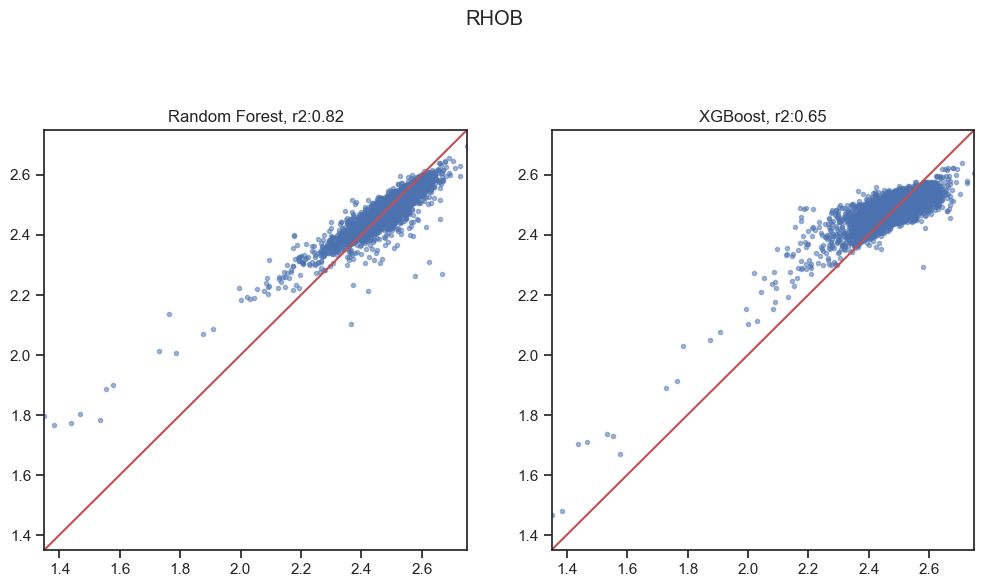

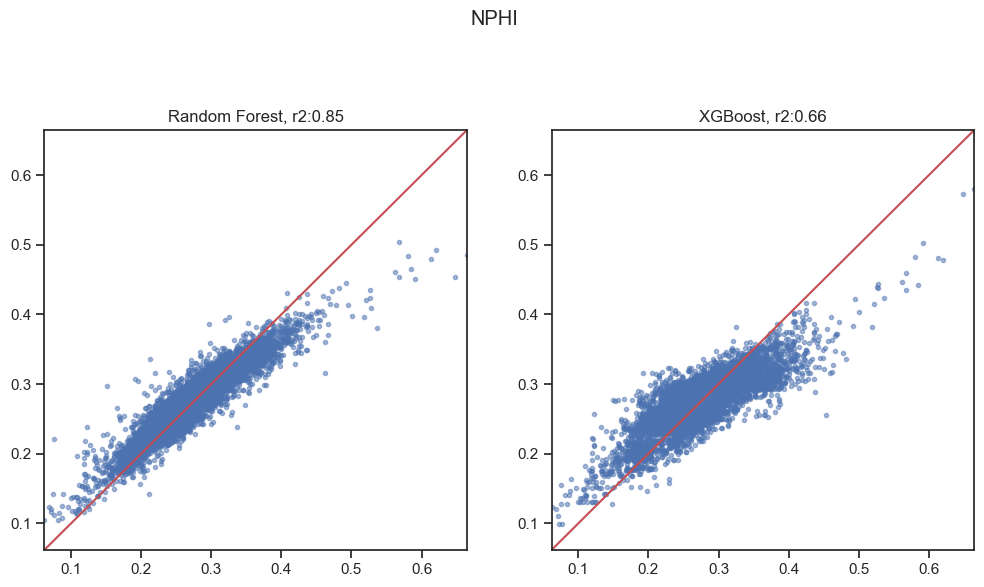

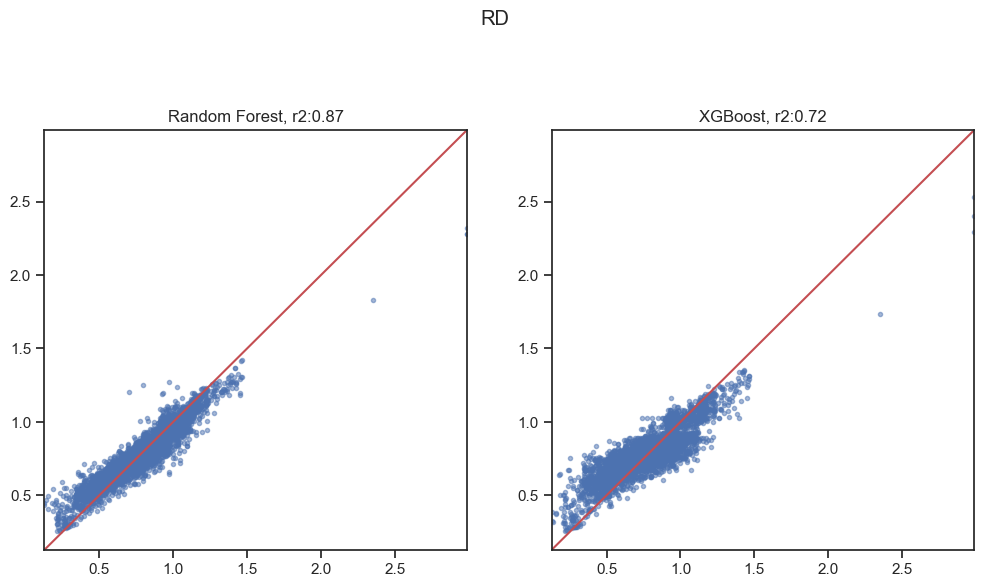

In [39]:
for i in range(3):
    x_min, x_max = train_y[:,i].min(), train_y[:,i].max()
    solid_line = [x_min, x_max]

    plt.figure(figsize=(12,12))

    plt.suptitle('{}'.format(Feature_name[i]))

    plt.subplot(221)
    plt.plot(train_y[:,i], train_y_pred_rf[:,i], '.', alpha=0.5)
    plt.plot(solid_line, solid_line, c='r')
    plt.xlim(x_min, x_max)
    plt.ylim(x_min, x_max)
    plt.title('Random Forest, r2:{:.2f}'.format(r2_rf2[i]))

    plt.subplot(222)
    plt.plot(train_y[:,i], train_y_pred_xg[:,i], '.', alpha=0.5)
    plt.plot(solid_line, solid_line, c='r')
    plt.xlim(x_min, x_max)
    plt.ylim(x_min, x_max)
    plt.title('XGBoost, r2:{:.2f}'.format(r2_xg2[i]))

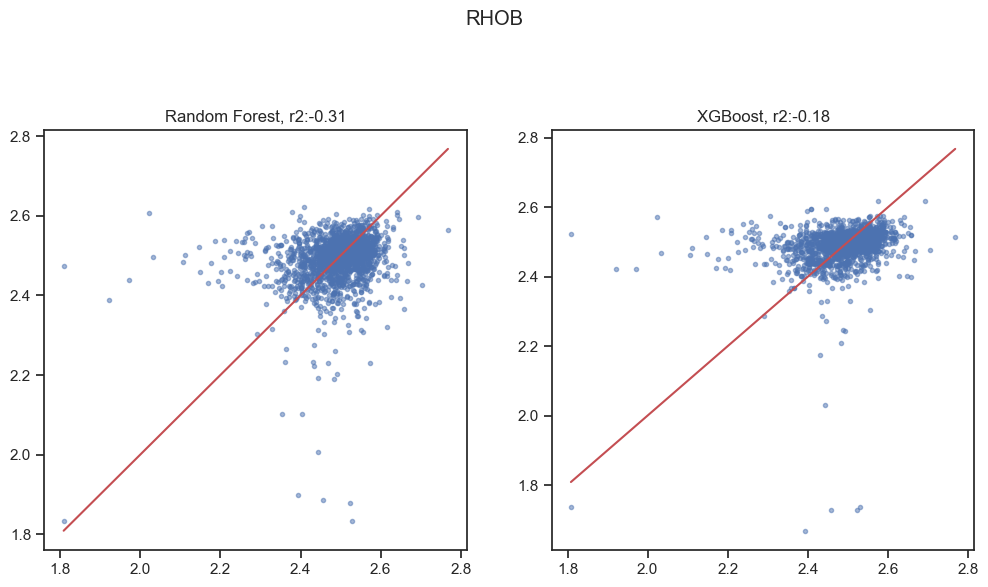

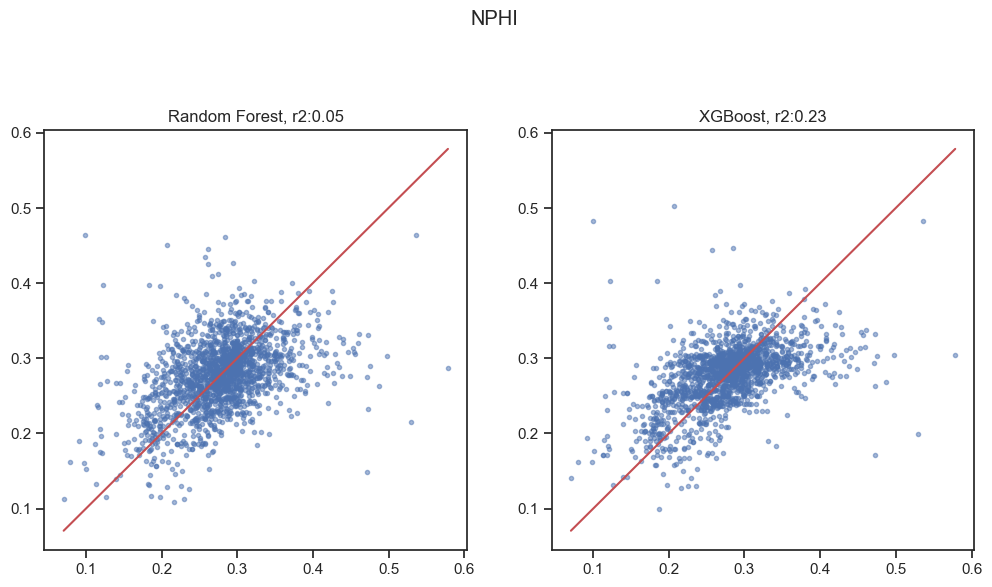

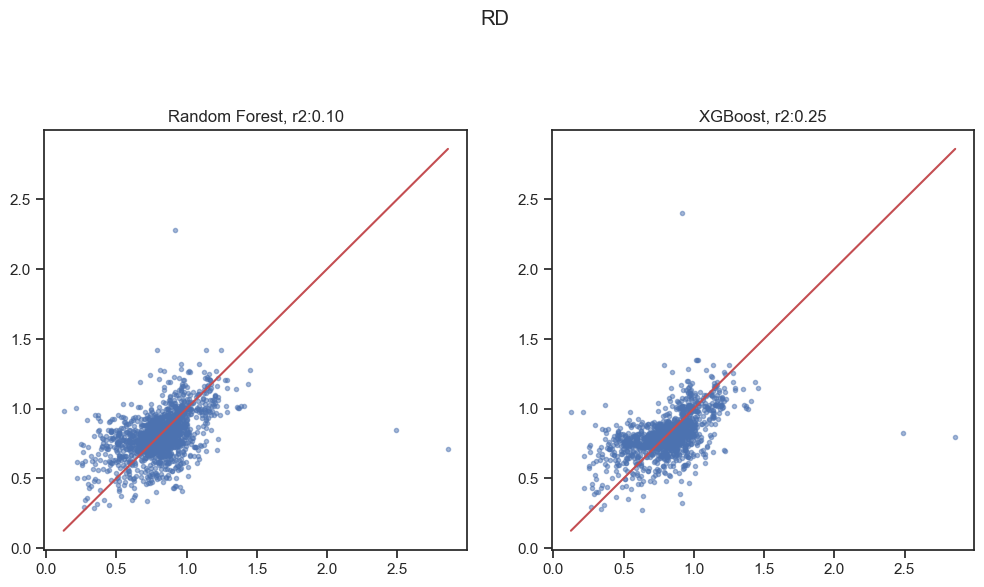

In [41]:
for i in range(3):
    x_min, x_max = val_y[:,i].min(), val_y[:,i].max()
    solid_line = [x_min, x_max]

    plt.figure(figsize=(12,12))

    plt.suptitle('{}'.format(Feature_name[i]))

    plt.subplot(221)
    plt.plot(val_y[:,i], val_y_pred_rf[:,i], '.', alpha=0.5)
    plt.plot(solid_line, solid_line, c='r')
    # plt.xlim(x_min, x_max)
    # plt.ylim(x_min, x_max)
    plt.title('Random Forest, r2:{:.2f}'.format(r2_rf3[i]))

    plt.subplot(222)
    plt.plot(val_y[:,i], val_y_pred_xg[:,i], '.', alpha=0.5)
    plt.plot(solid_line, solid_line, c='r')
    # plt.xlim(x_min, x_max)
    # plt.ylim(x_min, x_max)
    plt.title('XGBoost, r2:{:.2f}'.format(r2_xg3[i]))

In [46]:
from sklearn.linear_model import LinearRegression

In [63]:
lin_reg = LinearRegression()

lin_reg.fit(x_train, y_train)

LinearRegression()

In [64]:
y_val_pred = lin_reg.predict(x_val)

for i in range(3):
    print(r2_score(y_val[:, i], y_val_pred[:, i]))

-0.0024948961753143983
0.06971102255390271
0.17444766066187345


In [52]:
y_train_pred = lin_reg.predict(x_train)

for i in range(3):
    print(r2_score(y_train[:, i], y_train_pred[:, i]))

0.04846849701673417
0.25295068140088717
0.35770893471417764


In [56]:
print(r2_lin, r2_lin2)

[0.042146534381258594, 0.21472629224972195, 0.2984458657391258] [0.032411330209558886, 0.2567884944757397, 0.33364554843933647]
